In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [188]:

t_i = 0 # intial time
t_f = 1#final time
# I left nsteps to 75 so it can work properly with the optimization processes
nsteps = 75# number of steps between intial and final times
time = np.linspace(t_i,t_f, nsteps)
#h = (t_f-t_i)/nsteps # increments
h=0.001 # this could make |deltaT * f'(t)| < 1


time
counts_1
prob_1
tot_counts


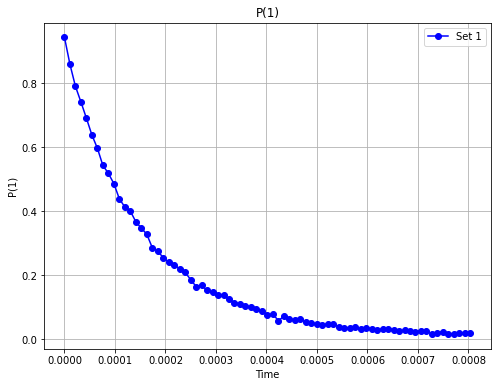

In [189]:
#data from real device

import json

file_path = '/Users/Pashlene/Desktop/T1_data_proc.json'

try:
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Iterate through the list of dictionaries
    for dictionary in data:
        print(dictionary)
except FileNotFoundError:
    print(f"The file '{file_path}' does not exist.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    
    
# Create an empty list to store the lists of data
data_lists = []

# Iterate through the dictionary keys and values
for key, value in data.items():
    data_lists.append(value)
    

time1=data_lists[0]
datas=data_lists[2]



# Create a plot
plt.figure(figsize=(8, 6)) 
plt.plot(time1, datas, label='Set 1', marker='o', linestyle='-', color='blue')

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('P(1)')
plt.title('P(1)')
plt.legend()

# Show the plot
plt.grid(True) 
plt.show()




In [214]:
#this function can be adjust to add more parameters easily
def Tmodel(x,y):
    w = 4.5 #ghz
    J = 8.2# from T1 and in ghz
    gamma = 5.15 #ghz
    ns = 10**(-9) # ns
    id4 = ns*np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    L =  complex(0, 1) * np.array([[0, J, -J, 0], [J, -w, 0, -J], [-J, 0, w, J], [0, -J, J, 0]])
    Phi1 = ns*np.array([[0, 0, 0, 0], [0, 1j, 0, 0], [0, 0, -1j, 0], [0, 0, 0, 0]])
    Phi2 = ns*np.array([[0, 0, 0, 0], [0, -1j, 0, 0], [0, 0, 1j, 0], [0, 0, 0, 0]])
    Theta1 = ns*np.array([[2*y, 0, 0, 0], [0, complex(y, x), 0, 0], [0, 0, complex(y, -x), 0], [0, 0, 0, 0]])
    Theta2 = ns*np.array([[0, 0, 0, 0], [0, complex(y, -x), 0, 0], [0, 0, complex(y, x), 0], [0, 0, 0, 2*y]])

    Nmax = 6
    
    current_state=np.zeros((Nmax,4,1), dtype=complex)
    prev=np.zeros((Nmax,4,1), dtype=complex)
    
    current_state[0,0]=1.0 # inital value for p
    prev[0]=current_state[0]

    p_matrix=np.zeros((nsteps,4,1),dtype=complex) # matrix that stores the matrices for d/dt(p)(results)
    p_matrix[0]=current_state[0]
    
    for index in range(1, len(time)):
        current_state[0] = prev[0] + h*(np.dot(L, prev[0]) + np.dot(Phi1, prev[1]) + np.dot(Phi2, prev[2]))
        p_matrix[index]=current_state[0] 
        current_state[1] = prev[1] + h*(np.dot(L - gamma * id4, prev[1]) + np.dot(Phi1, prev[5]) + np.dot(Phi2, prev[3]) + np.dot(Theta2, prev[0]))
        current_state[2] = prev[2] + h*(np.dot(L - gamma * id4, prev[2]) + np.dot(Phi2, prev[5]) + np.dot(Phi1, prev[4]) + np.dot(Theta1, prev[0]))
        current_state[3] = prev[3] + h*(np.dot(L, prev[3]))
        current_state[4] = prev[4] + h*(np.dot(L, prev[4]))
        current_state[5] = prev[5] + h*(np.dot(L, prev[5]))
        prev=current_state
        
    
    sol=p_matrix[:,0,0]
        
    return sol

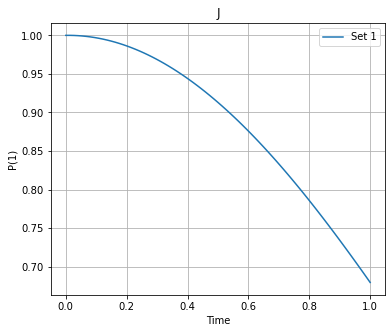

In [216]:
x = 2*(53) #ghz
y = (40) #ghz
initial_x = x
initial_y = y
plt.figure(figsize=(6, 5))
plt.plot(time, np.real(Tmodel(x,y)), label='Set 1') 

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('P(1)')
plt.title('J')
plt.legend()

# Show the plot
plt.grid(True)  
plt.show()

In [217]:
experimental=datas
predicted = Tmodel(x,y)

In [218]:
import numpy as np

def mse(observations, estimates):
    dlen = len(observations)
    obav = sum(observations) / dlen  # Calculate the mean

    diff = np.abs(np.array(observations) - np.array(estimates))
    var = np.abs(np.array(observations) - obav)

    sq_diff = sum(diff) ** 2  # Sum of squared differences
    sq_var = sum(var) ** 2  # Sum of squared variations

    mse = sq_diff / dlen
    variance = sq_var / dlen
    r2=(1-(mse/variance))*100

    return mse,r2
    
MSE,R2= mse(experimental, predicted)

print(MSE)
print(R2)

36.72667263421783
-1532.8833717566


In [219]:
# Minimise the LstSqrs Function

def minmse(x,y):
    experimental=datas
    predicted = Tmodel(x,y)
    return mse(experimental, predicted)

ans=minmse(x,y)[0]
print(ans)

36.72667263421783


In [220]:
import jax
import jax.numpy as jnp
J = jax.jacrev(minmse)
print(J)

<function minmse at 0x7fa1bbb0c160>


In [221]:
import numpy as np
import jax
import jax.numpy as jnp

minfunc = minmse(x,y)[0]

scorelst = []
tlst = []

def adam_numpy(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
    prm = np.array(bound)  # Convert bound to a NumPy array
    first = prm.copy()  # Copy initial parameters to first
    best = prm.copy()  # Copy initial parameters to best
    worst = prm.copy()  # Copy initial parameters to worst
    score = minfunc  

    scbest = score
    print('f(%s) = %f' % (prm, score))

    m = np.zeros(len(prm))
    v = np.zeros(len(prm))

    for t in range(n_iter + 1):
        #calculate gradients for x and y which are the parameters we want to optimise in theta1 and theta2
        #could not use jax here so adjusted code with numpy
        epsilon = 1e-5 
        g = np.zeros(len(prm))
        prm_plus_epsilon = prm.copy()
        prm_plus_epsilon[0] += epsilon
        prm_plus_epsilon[1] += epsilon
        g=(minmse(prm_plus_epsilon[0],prm_plus_epsilon[1])-score)/epsilon

        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2

        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))

        prm = prm - alpha * mhat / (np.sqrt(vhat) + eps)

        for i in range(len(prm)):
            if prm[i] < 0:
                prm[i] = bound[i]

        if scbest > minmse(prm[0],prm[1])[0]:
            best = prm.copy()
            scbest = minmse(np.array([best]))[0]

        # Evaluate the candidate point
        score = minmse(prm[0],prm[1])[0]
        scorelst.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))

    return [best, scbest]



# Run the gradient descent algorithm
bounds=np.array([x,y])
# define the total iterations
n_iter = 500
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999


# perform the gradient descent search with adam
best_prms, score = adam_numpy([x,y], n_iter, alpha, beta1,beta2)
print('Done!')
print('f(%s) = %f' % (best_prms, score))

f([106  40]) = 36.726673
>0 => 36.726673
>1 => 36.726673
>2 => 36.726673
>3 => 36.726673
>4 => 36.726673
>5 => 36.726673
>6 => 36.726673
>7 => 36.726673
>8 => 36.726673
>9 => 36.726673
>10 => 36.726673
>11 => 36.726673
>12 => 36.726673
>13 => 36.726673
>14 => 36.726673
>15 => 36.726673
>16 => 36.726673
>17 => 36.726673
>18 => 36.726673
>19 => 36.726673
>20 => 36.726673
>21 => 36.726673
>22 => 36.726673
>23 => 36.726673
>24 => 36.726673
>25 => 36.726673
>26 => 36.726673
>27 => 36.726673
>28 => 36.726673
>29 => 36.726673
>30 => 36.726673
>31 => 36.726673
>32 => 36.726673
>33 => 36.726673
>34 => 36.726673
>35 => 36.726673
>36 => 36.726673
>37 => 36.726673
>38 => 36.726673
>39 => 36.726673
>40 => 36.726673
>41 => 36.726673
>42 => 36.726673
>43 => 36.726673
>44 => 36.726673
>45 => 36.726673
>46 => 36.726673
>47 => 36.726673
>48 => 36.726673
>49 => 36.726673
>50 => 36.726673
>51 => 36.726673
>52 => 36.726673
>53 => 36.726673
>54 => 36.726673
>55 => 36.726673
>56 => 36.726673
>57 => 36.726673

In [222]:
Tmodelbest=Tmodel(*best_prms)

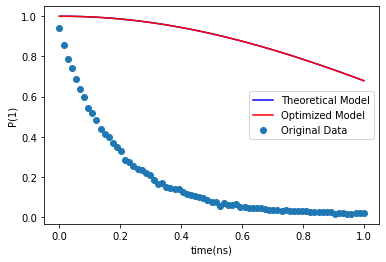

Optimized Slope (x): 106
Optimized Intercept (y): 40


In [223]:

plt.scatter(time, datas, label='Original Data')
#theoretical data and optimized data is plotted on top of each other
plt.plot(time, np.real(Tmodel(initial_x, initial_y)), 'b', label='Theoretical Model') 
plt.plot(time, np.real(Tmodelbest), 'r', label='Optimized Model')
plt.xlabel('time(ns)')
plt.ylabel('P(1)')
plt.legend()
plt.show()

print(f"Optimized Slope (x): {best_prms[0]}")
print(f"Optimized Intercept (y): {best_prms[1]}")

In [224]:
# Normal gradient descent
experimental=datas
predicted = Tmodel(x,y)

def objective_function(x, y):
    predicted = Tmodel(x,y)
    mse = np.mean((predicted - experimental) ** 2)
    return mse

In [225]:
def gradient_descent(x, y, learning_rate, num_iterations):
    for i in range(num_iterations):
        # Compute the gradients of the objective function with respect to m and b
        gradient_x = (objective_function(x + epsilon, y) - objective_function(x, y)) / epsilon
        gradient_y = (objective_function(x, y + epsilon) - objective_function(x, y)) / epsilon

        # Update m and b using the gradients
        x -= learning_rate * gradient_x 
        y -= learning_rate * gradient_y 

        # Compute the new objective value
        objective_value = objective_function(x, y) 

        # Print the progress
        if i % 10 == 0:
            print(f"Iteration {i}: x = {x}, y = {y}, MSE = {objective_value}")

    return x, y

Iteration 0: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 10: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 20: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 30: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 40: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 50: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 60: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 70: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 80: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)
Iteration 90: x = (1060000000+0j), y = (400000000+0j), MSE = (0.5189509495403444+0j)


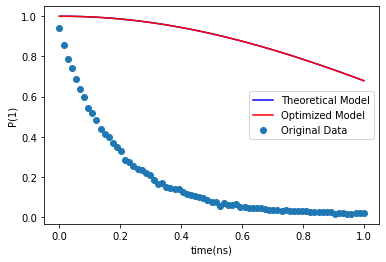

Optimized Slope (x): (1060000000+0j)
Optimized Intercept (y): (400000000+0j)


In [226]:
# Initialize m and b with some initial values
x = 2 *(0.53e9)
y = (0.40e9)
initial_x = x
initial_y = y

# Set hyperparameters
learning_rate = 0.01
num_iterations = 100

# Define a small epsilon for gradient computation
epsilon = 1e-1
#normal gradient descent
# Call gradient descent to optimize m and b
optimized_x, optimized_y = gradient_descent(initial_x, initial_y, learning_rate, num_iterations)

# Plot the original data and the optimized linear regression model
plt.scatter(time, datas, label='Original Data')
plt.plot(time, np.real(Tmodel(initial_x, initial_y)), 'b', label='Theoretical Model')
plt.plot(time, np.real(Tmodel(optimized_x, optimized_y)), 'r', label='Optimized Model')
plt.xlabel('time(ns)')
plt.ylabel('P(1)')
plt.legend()
plt.show()

print(f"Optimized Slope (x): {optimized_x}")
print(f"Optimized Intercept (y): {optimized_y}")